In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 20
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2002-04-10', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


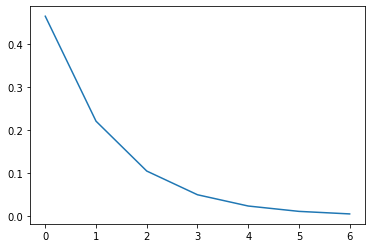

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                                Close  \
         ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
0  1130.469971  1767.069946  6315.899902  10650.919922  1130.469971   
1  1103.689941  1725.239990  6181.189941  10419.740234  1103.689941   
2  1111.010010  1756.189941  6217.350098  10505.969727  1111.010010   
3  1102.550049  1753.780029  6173.470215  10437.839844  1102.550049   
4  1128.369995  1816.790039  6288.509766  10669.410156  1128.369995   

                                                  High               ...  \
         ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC  ...   
0  1767.069946  6315.899902  10650.919922  1131.760010  1772.000000  ...   
1  1725.239990  6181.189941  10419.740234  1130.469971  1762.280029  ...   
2  1756.189941  6217.350098  10505.969727  1112.770020  1756.329956  ...   
3  1753.780029  6173.470215  10437.839844  1114.859985  1769.040039  ...   
4  1816.790039  6288.509766  10669.410156  1129.400024  1816.910034  ...   

  DayToDayChange OvernightChange LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000    mine1          mine1          mine1   
0            NaN             NaN      NaN            NaN            NaN   
1       0.978295        0.978295      NaN            NaN            NaN   
2       1.008276        1.008276      NaN            NaN            NaN   
3       0.993515        0.993515      NaN            NaN            NaN   
4       1.022186        1.022186      NaN            NaN            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  
            mine1    mine2          mine2          mine2           mine2  
0             NaN      NaN            NaN            NaN             NaN  
1             NaN      NaN            NaN            NaN             NaN  
2             NaN      NaN            NaN            NaN             NaN  
3             NaN      NaN            NaN            NaN             NaN  
4             NaN      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

5032   2022-04-04
5033   2022-04-05
5034   2022-04-06
5035   2022-04-07
5036   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                                Close  \
                  ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
Date                                                                           
2002-04-10  1130.469971  1767.069946  6315.899902  10650.919922  1130.469971   
2002-04-11  1103.689941  1725.239990  6181.189941  10419.740234  1103.689941   
2002-04-12  1111.010010  1756.189941  6217.350098  10505.969727  1111.010010   
2002-04-15  1102.550049  1753.780029  6173.470215  10437.839844  1102.550049   
2002-04-16  1128.369995  1816.790039  6288.509766  10669.410156  1128.369995   

                                                           High               \
                  ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC   
Date                                                                           
2002-04-10  1767.069946  6315.899902  10650.919922  1131.760010  1772.000000   
2002-04-11  1725.239990  6181.189941  10419.740234  1130.469971  1762.280029   
2002-04-12  1756.189941  6217.350098  10505.969727  1112.770020  1756.329956   
2002-04-15  1753.780029  6173.470215  10437.839844  1114.859985  1769.040039   
2002-04-16  1816.790039  6288.509766  10669.410156  1129.400024  1816.910034   

            ... DayToDayChange OvernightChange LogValue IntradayChange  \
            ...         ^W5000          ^W5000    mine1          mine1   
Date        ...                                                          
2002-04-10  ...            NaN             NaN      NaN            NaN   
2002-04-11  ...       0.978295        0.978295      NaN            NaN   
2002-04-12  ...       1.008276        1.008276      NaN            NaN   
2002-04-15  ...       0.993515        0.993515      NaN            NaN   
2002-04-16  ...       1.022186        1.022186      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
2002-04-10            NaN             NaN      NaN            NaN   
2002-04-11            NaN             NaN      NaN            NaN   
2002-04-12            NaN             NaN      NaN            NaN   
2002-04-15            NaN             NaN      NaN            NaN   
2002-04-16            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
2002-04-10            NaN             NaN  
2002-04-11            NaN             NaN  
2002-04-12            NaN             NaN  
2002-04-15            NaN             NaN  
2002-04-16            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4645154651920107
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4645154651920107
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
Round: 90


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 3.4645154651920107
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adju

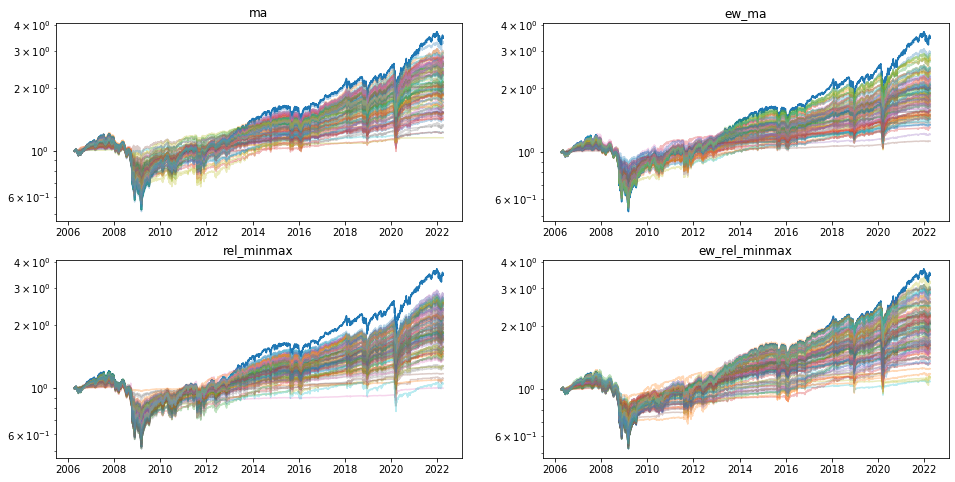

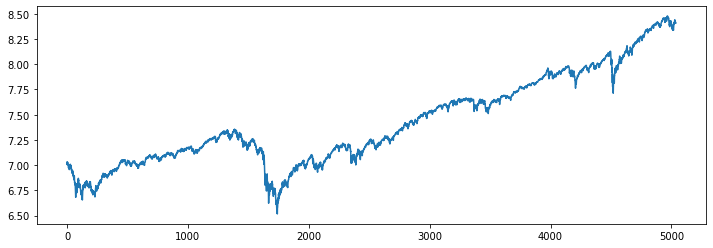

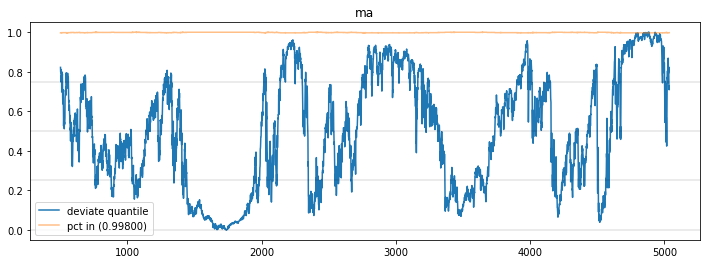

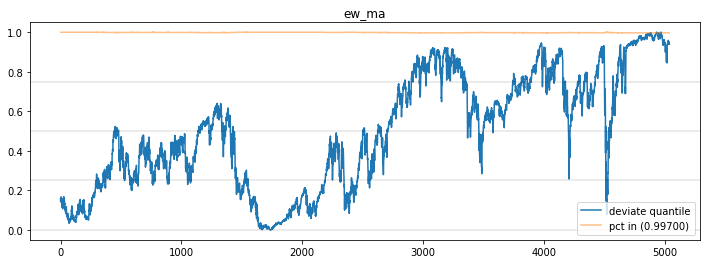

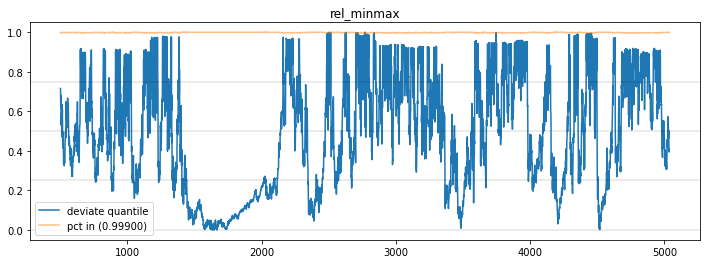

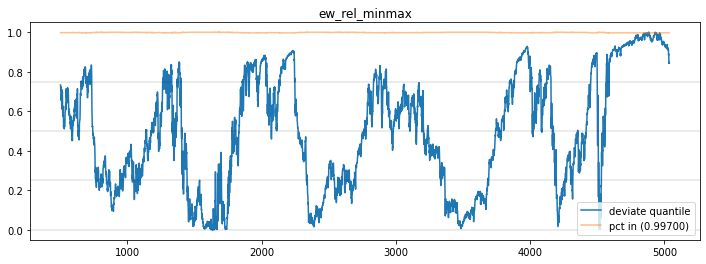

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.861856626070154
Refitting current best...
Current best ma returns: 6.503886650897863
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 6.503888163386901
Invested: 1.0
New best: 6.504209282870604
Invested: 1.0
New best: 6.504217333769095
Invested: 1.0
New best: 6.504224867025418
Invested: 1.0
New best: 6.543518680258334
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.861856626070154
Refitting current best...
Current best ew_ma returns: 6.425851532796284
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
Ne

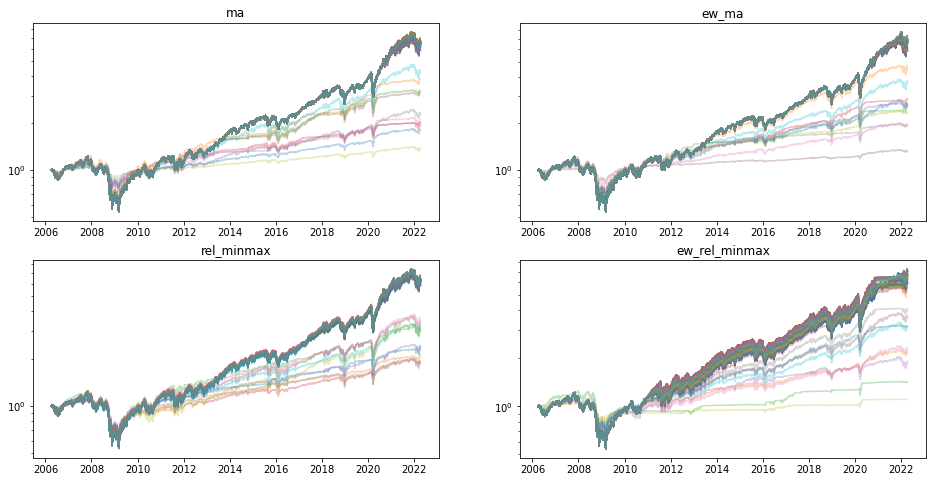

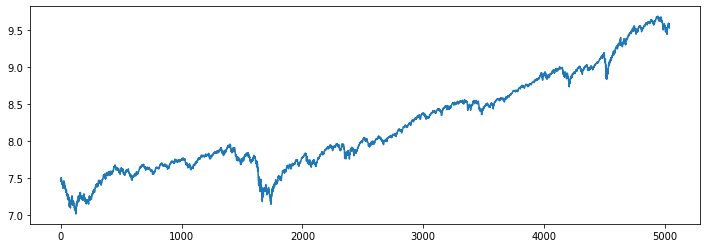

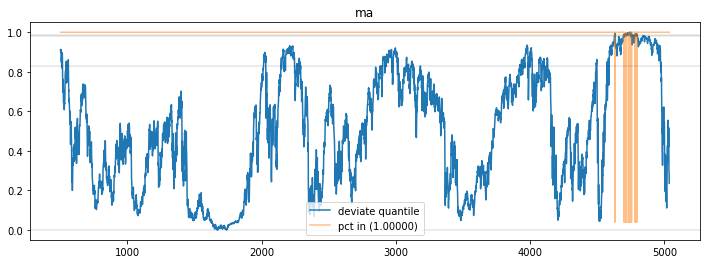

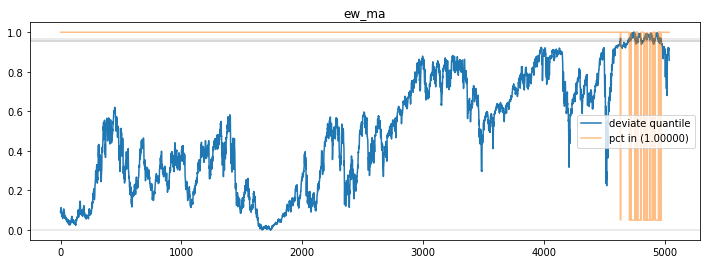

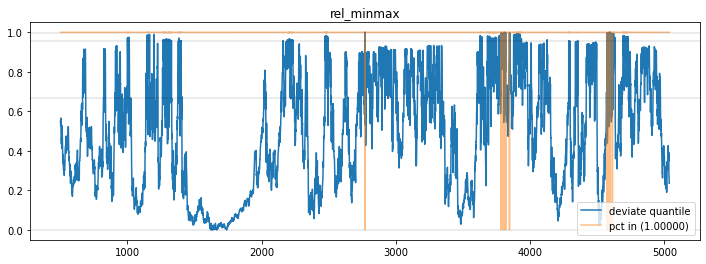

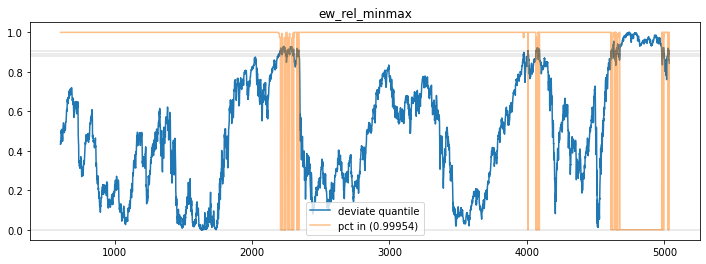

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.0179730045981024
Refitting current best...
Current best ma returns: 2.5031038475588074
Fraction Invested: 0.9986857303714567
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.6140125957091427
Invested: 0.9986857303714567
New best: 2.6165952515229005
Invested: 0.9986857303714567
New best: 2.6171981772552098
Invested: 0.9990984117995532
New best: 2.6178447977963373
Invested: 0.9995409456471405
New best: 2.6290356007227627
Invested: 0.9995409456471405
New best: 2.629035857303632
Invested: 0.9995409456471405
New best: 2.6297776390682195
Invested: 0.9995409456471405
New best: 2.630357327236866
Invested: 0.9999358243123405
Round: 90


Beginning 

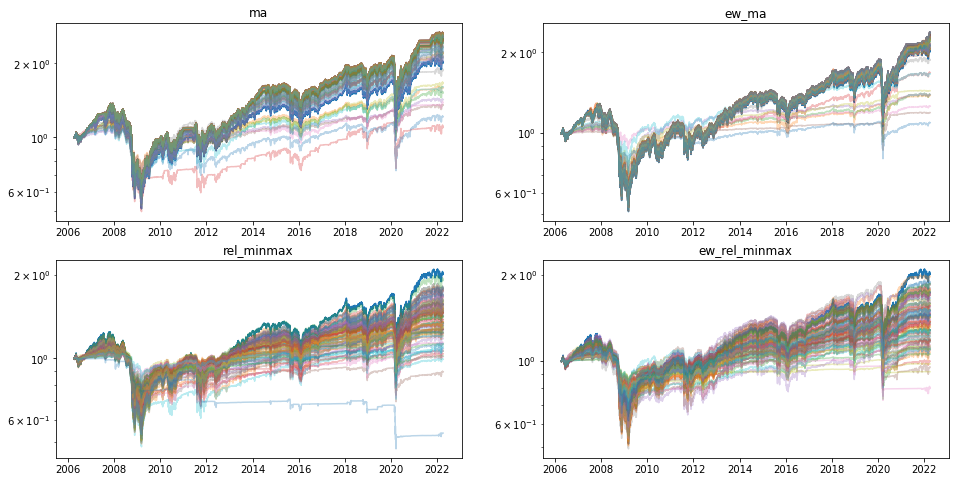

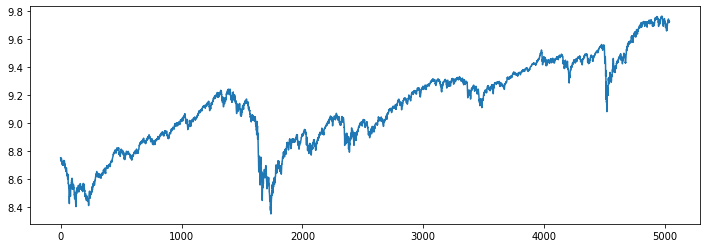

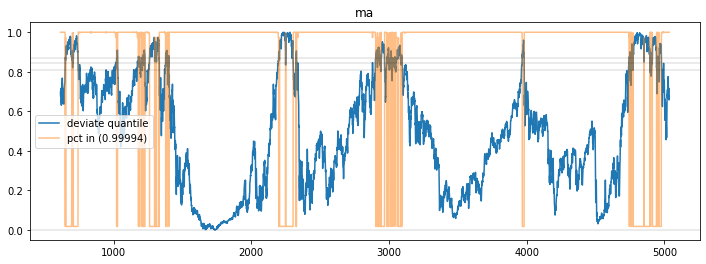

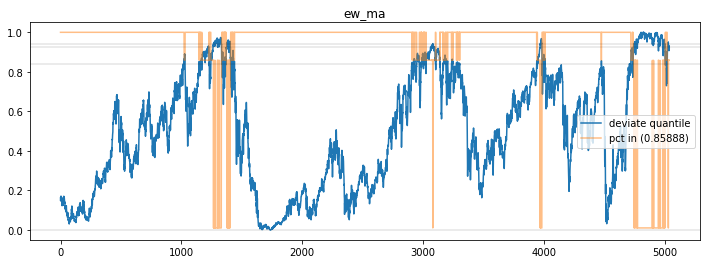

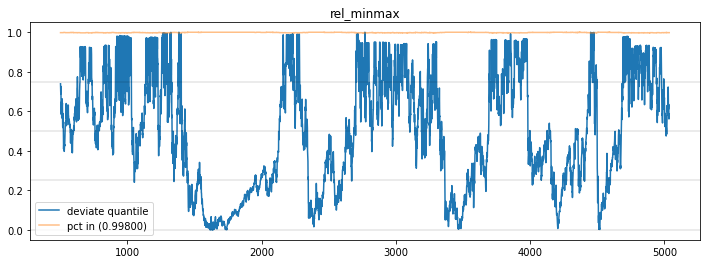

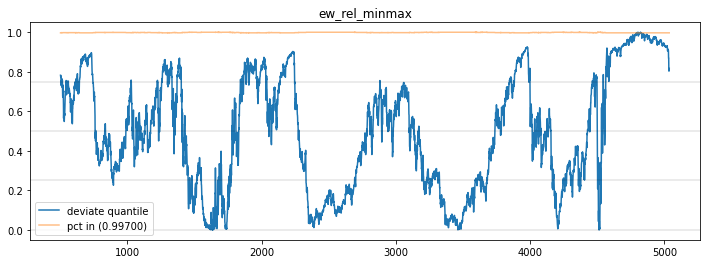

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4193457663298283
Refitting current best...
Current best ma returns: 3.7276800240036887
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.7351964056650773
Invested: 1.0
New best: 3.735419715553536
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4193457663298283
Refitting current best...
Current best ew_ma returns: 3.8637658689677856
Fraction Invested: 0.003070506272812107
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 4.138364683696938
Invested: 0.003070506272812107
New best: 4.156160375555309
Invested: 0.0030705

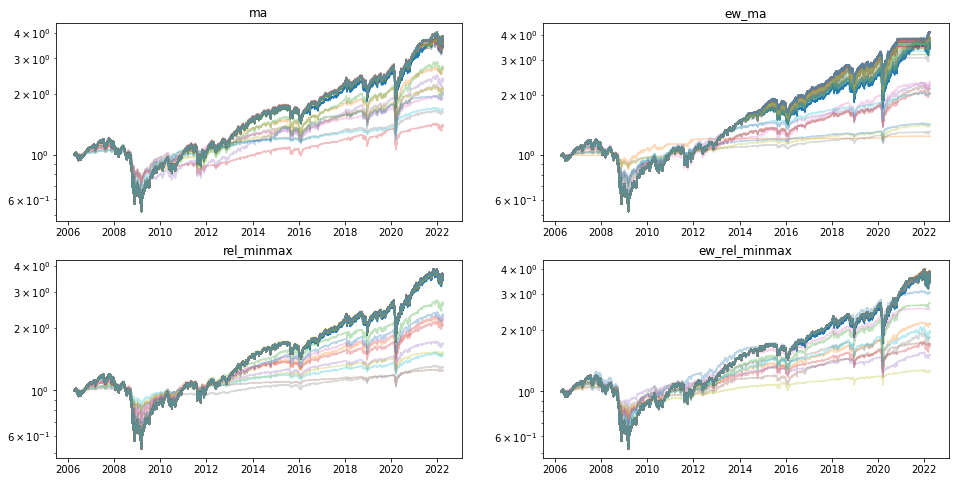

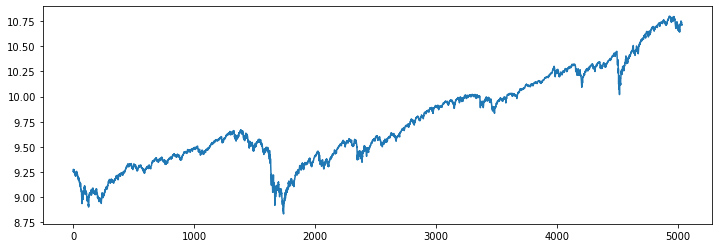

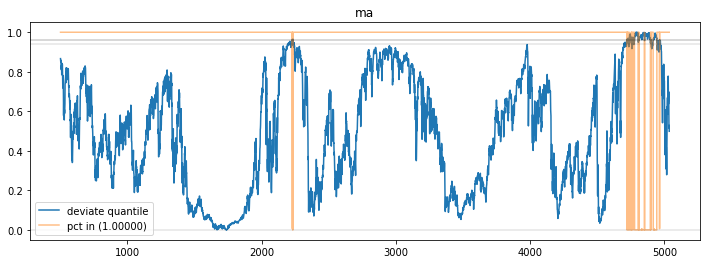

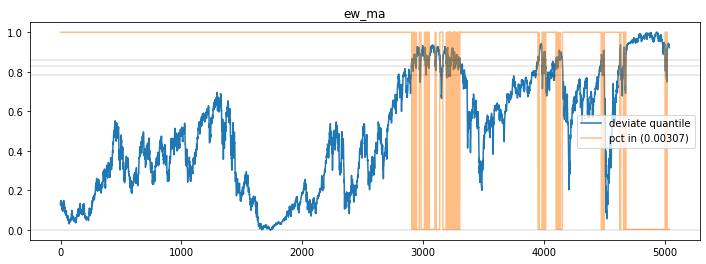

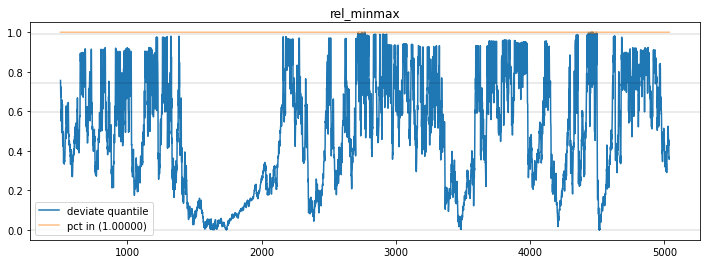

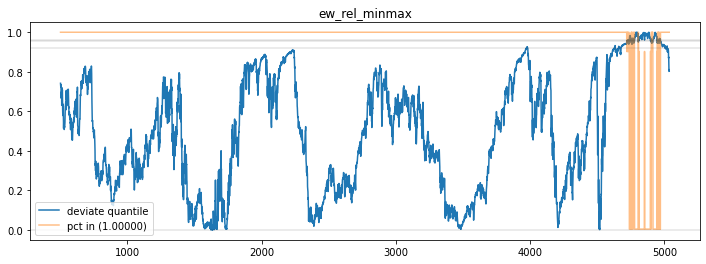

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ma returns: 15.094881539957408
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 15.094957786988642
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ew_ma returns: 16.070275723845178
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 90


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Curre

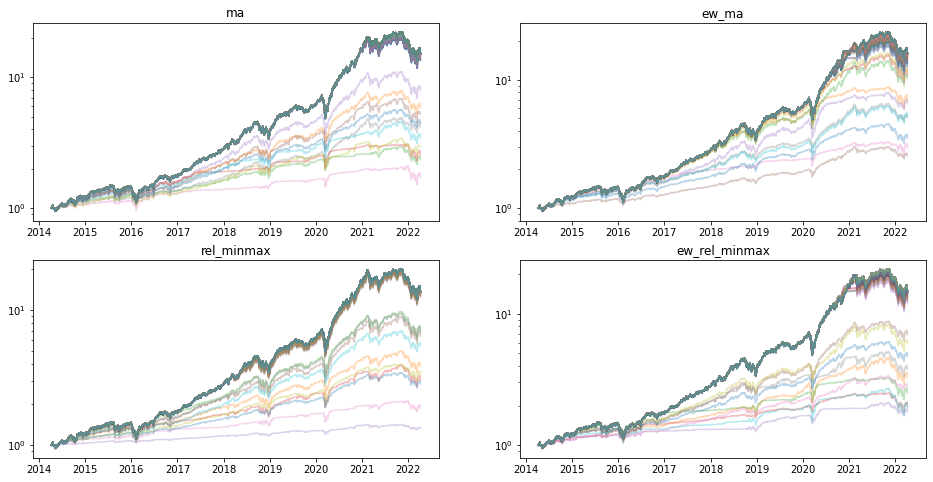

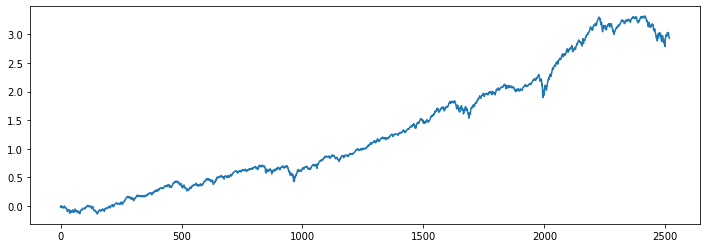

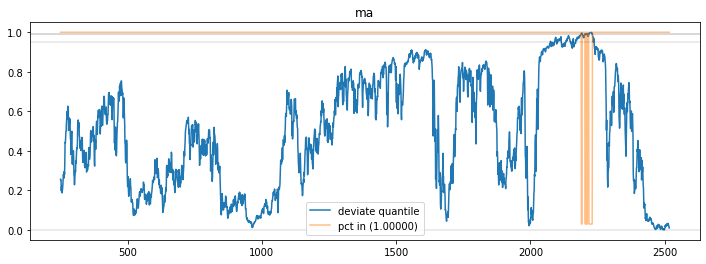

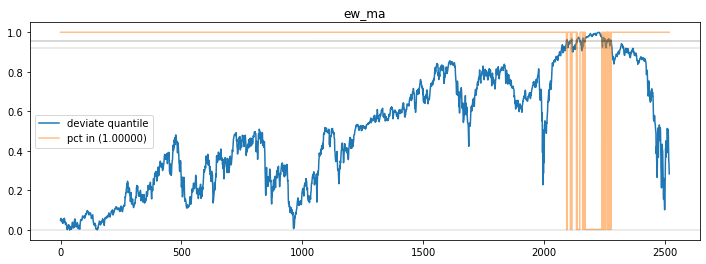

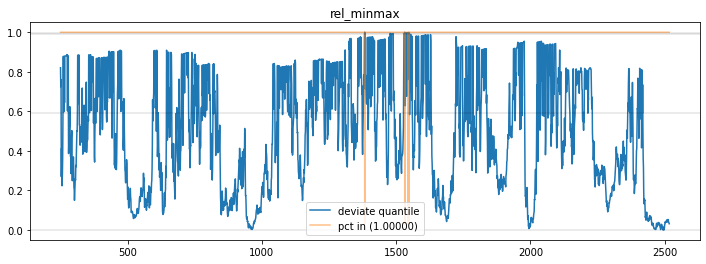

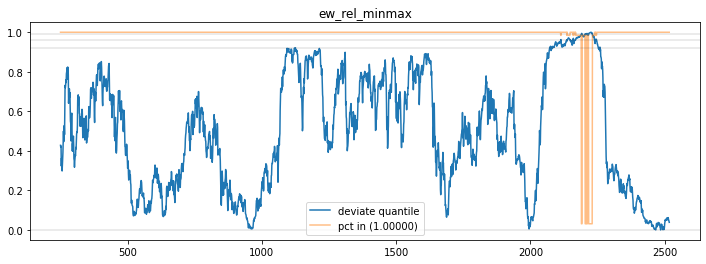

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ma returns: 6.583545984954714
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 6.677815114019461
Invested: 1.0
New best: 6.7178603073393734
Invested: 1.0
New best: 6.717887042962646
Invested: 1.0
New best: 6.718567360587527
Invested: 1.0
New best: 6.718618299964408
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ew_ma returns: 7.435281252963712
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
N

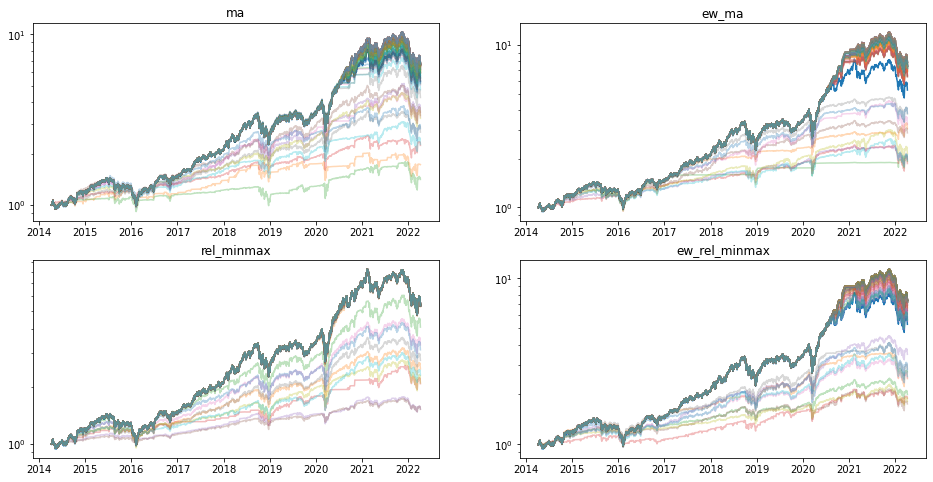

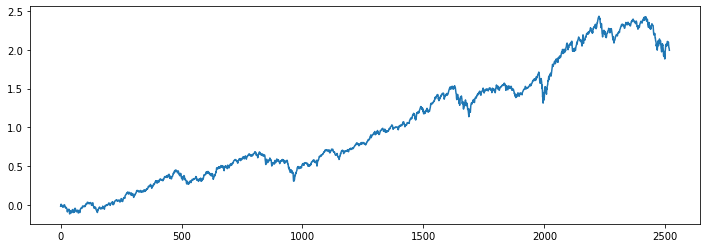

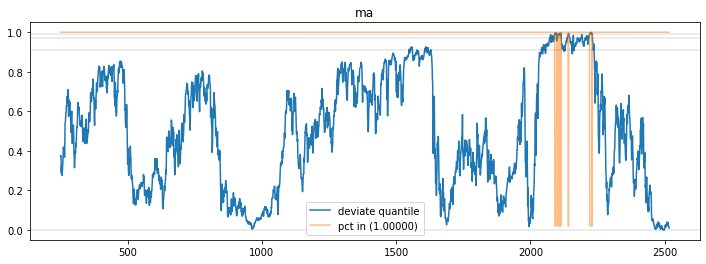

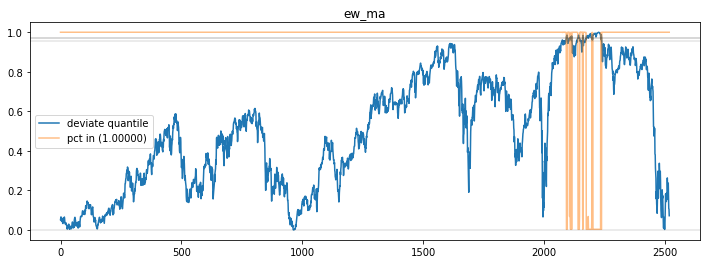

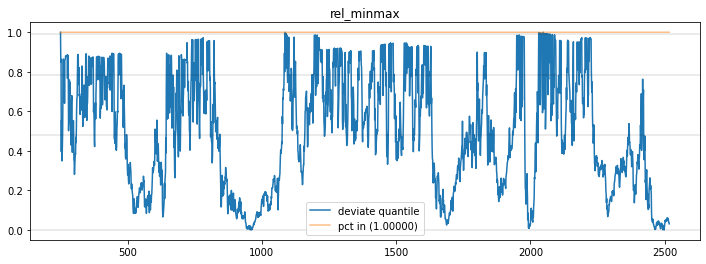

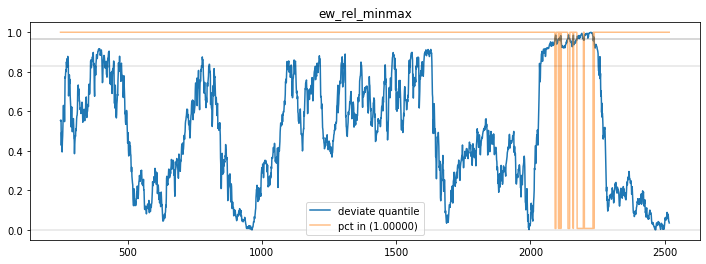

Saving mine2 params...


In [39]:
#N_RAND = 10
#N_ADJ = 90

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [53]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [54]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 3.4645154651920107 (ma)
  1.00000000 in
time param: 503
qs:
(0.0000 - 0.2500): 1.0000
(0.2500 - 0.5000): 0.9990
(0.5000 - 0.7500): 0.9980
(0.7500 - 1.0000): 0.9970

^IXIC:
  Best Return: 7.084638242110592 (ew_rel_minmax)
  0.99953877 in
time param: 607
qs:
(0.0000 - 0.8787): 0.9995
(0.8787 - 0.8892): 0.9945
(0.8892 - 0.9054): 0.9736
(0.9054 - 1.0000): 0.0008

^NYA:
  Best Return: 2.630357327236866 (ma)
  0.99993582 in
time param: 616
qs:
(0.0000 - 0.8077): 0.9999
(0.8077 - 0.8434): 0.9975
(0.8434 - 0.8672): 0.9732
(0.8672 - 1.0000): 0.0177

^W5000:
  Best Return: 4.156179657130993 (ew_ma)
  0.00307051 in
time param: 503
qs:
(0.0000 - 0.7839): 1.0000
(0.7839 - 0.8285): 1.0000
(0.8285 - 0.8585): 0.9992
(0.8585 - 1.0000): 0.0031

mine1:
  Best Return: 16.070275723845178 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9192): 1.0000
(0.9192 - 0.9565): 1.0000
(0.9565 - 0.9566): 0.9473
(0.9566 - 1.0000): 0.0025

mine2:
  Best Return: 7.848668499794003 (ew_ma)
  

{'^GSPC': {'best_return': 3.4645154651920107, 'pct_in': 1},
 '^IXIC': {'best_return': 7.084638242110592, 'pct_in': 0.999538766768611},
 '^NYA': {'best_return': 2.630357327236866, 'pct_in': 0.9999358243123405},
 '^W5000': {'best_return': 4.156179657130993, 'pct_in': 0.003070506272812107},
 'mine1': {'best_return': 16.070275723845178, 'pct_in': 1.0},
 'mine2': {'best_return': 7.848668499794003, 'pct_in': 1.0}}

In [55]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 3.4645154651920107, 'pct_in': 1, 'weight': 0},
 '^IXIC': {'best_return': 7.084638242110592,
  'pct_in': 0.999538766768611,
  'weight': 1.2085997140568419},
 '^NYA': {'best_return': 2.630357327236866,
  'pct_in': 0.9999358243123405,
  'weight': 1.3034650717543794},
 '^W5000': {'best_return': 4.156179657130993,
  'pct_in': 0.003070506272812107,
  'weight': 1.2154897284903858},
 'mine1': {'best_return': 16.070275723845178,
  'pct_in': 1.0,
  'weight': 0.5964937565479912},
 'mine2': {'best_return': 7.848668499794003,
  'pct_in': 1.0,
  'weight': 0.741332676523562}}

In [56]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [57]:
!say qp is dunzo